<a href="https://colab.research.google.com/github/hamedebrahimi68/financial_markets_predictoin/blob/master/linear_reg_svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  1 of 1 completed


Train RMSE: 21478.174159310198
Test RMSE: 43595.930592201454
Length of train_index: 2812
Length of combined_train_predict: 2812
Length of test_index: 658
Length of combined_test_predict: 658


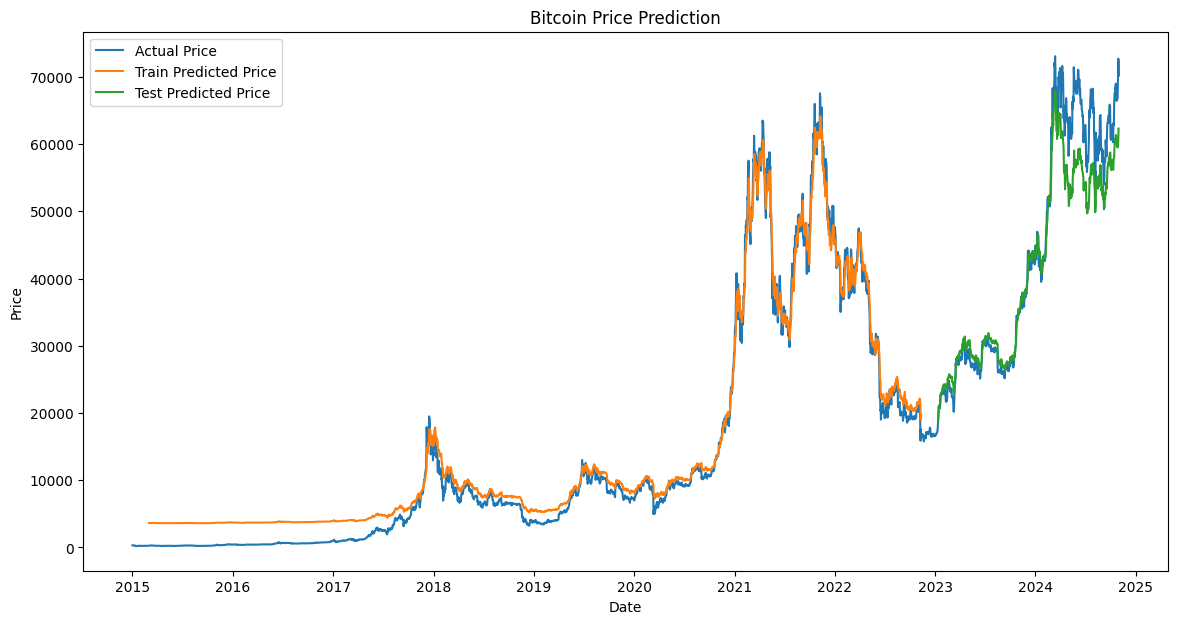

In [24]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Fetch Historical Bitcoin Price Data
ticker = 'BTC-USD'
data = yf.download(ticker, start='2015-01-01', end='2024-11-01')

# Split Data into Training and Testing Sets
train_size = int(len(data) * 0.8)  # Adjusted to 80% for training
train_data = data['Close'][:train_size]
test_data = data['Close'][train_size:]

# Normalize Data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data.values.reshape(-1, 1))
test_scaled = scaler.transform(test_data.values.reshape(-1, 1))

# Prepare Data for Linear Regression and SVM
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 60
X_train, y_train = create_dataset(train_scaled, time_step)
X_test, y_test = create_dataset(test_scaled, time_step)

# Check if X_test and y_test are not empty
if len(X_test) == 0 or len(y_test) == 0:
    raise ValueError('''Not enough data points for testing. Consider reducing the
    time_step or increasing the test dataset size.''')

# Reshape Input for Linear Regression and SVM
X_train_lr = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test_lr = X_test.reshape(X_test.shape[0], X_test.shape[1])

# Build Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train_lr, y_train)

# Build SVM Model
svm_model = SVR(kernel='rbf')
svm_model.fit(X_train_lr, y_train)  # Corrected 'Fit' to 'fit'

# Predict with Linear Regression Model
lr_train_predict = lr_model.predict(X_train_lr)
lr_test_predict = lr_model.predict(X_test_lr)

# Predict with SVM Model
svm_train_predict = svm_model.predict(X_train_lr)
svm_test_predict = svm_model.predict(X_test_lr)

# Inverse Transform Predictions
lr_train_predict = scaler.inverse_transform(lr_train_predict.reshape(-1, 1))
lr_test_predict = scaler.inverse_transform(lr_test_predict.reshape(-1, 1))
svm_train_predict = scaler.inverse_transform(svm_train_predict.reshape(-1, 1))
svm_test_predict = scaler.inverse_transform(svm_test_predict.reshape(-1, 1))

# Combine Predictions from Linear Regression and SVM
combined_train_predict = (lr_train_predict + svm_train_predict) / 2
combined_test_predict = (lr_test_predict + svm_test_predict) / 2

# Ensure the lengths of the arrays are consistent
assert len(y_train) == len(combined_train_predict), "Length mismatch in train data and predictions"
assert len(y_test) == len(combined_test_predict), "Length mismatch in test data and predictions"

# Evaluate Model
train_rmse = np.sqrt(mean_squared_error(y_train, combined_train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test, combined_test_predict))
print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

# Plot Results
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close'], label='Actual Price')

# Adjust the slicing to match the length of combined_train_predict
train_index = data.index[time_step:train_size - 1]
test_index = data.index[train_size + time_step:train_size + time_step + len(combined_test_predict)]

print(f"Length of train_index: {len(train_index)}")
print(f"Length of combined_train_predict: {len(combined_train_predict)}")
print(f"Length of test_index: {len(test_index)}")
print(f"Length of combined_test_predict: {len(combined_test_predict)}")

# Ensure the lengths match
assert len(train_index) == len(combined_train_predict), "Length mismatch in train index and predictions"
assert len(test_index) == len(combined_test_predict), "Length mismatch in test index and predictions"

plt.plot(train_index, combined_train_predict, label='Train Predicted Price')
plt.plot(test_index, combined_test_predict, label='Test Predicted Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Bitcoin Price Prediction')
plt.legend()
plt.show()

